In [1]:
!pip install tokenizers
import tensorflow as tf
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, Regex
import tokenizers
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10.9 MB/s eta 0:00:0000:0100:01


2023-05-04 09:35:34.748979: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 10.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 10.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.7 MB/s eta 0:00:00


In [3]:
model_name = 'roberta_base_cased'

# Load data

In [4]:
df = pd.read_csv('/home/user/files_for_research_Vova/processed_data.csv',\
                 usecols=['review_translate',
                                                            'dataset_name',
                                                            'rating',
                                                           'translated'])

In [5]:
df.head()

,review_translate,rating,dataset_name,translated
0,"Якісна пластмаса , переворот 360 градусвв",5.0,rozetka,False
1,За такі гроші це самий топ,5.0,rozetka,False
2,За такі гроші - просто супер ! Рекомендую .,5.0,rozetka,False
3,Виконує свою роботу не погано . але що ви хоті...,4.0,rozetka,False
4,Купляв на стару сістему як основний під віндов...,4.0,rozetka,False


In [6]:
subsets = pd.read_csv('/home/user/files_for_research_Vova/train_val_test_indices.csv')

In [7]:
subsets.head()

,index,split
0,0,train
1,1,test
2,2,train
3,3,train
4,4,train


In [8]:
subsets = subsets.merge(df[['dataset_name', 'translated']], left_on='index', right_index=True)

# Filter data

In [9]:
bad_indices = pd.read_csv('/home/user/files_for_research_Vova/files_to_check.csv')

In [10]:
subsets = subsets[~subsets.index.isin(bad_indices['id'].values)]

In [11]:
df = df[~df.index.isin(bad_indices['id'].values)]

In [12]:
df, subsets = df.reset_index().drop(columns='index'), subsets.reset_index().drop(columns='index')

# Load tokenizer

In [13]:
from transformers import AutoTokenizer

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
tokenizer = Ro.from_pretrained('youscan/ukr-roberta-base')

# Encode text

In [18]:
import seaborn as sns
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [19]:
sns.set()

In [20]:
def preprocess_function(examples):
    return tokenizer.batch_encode_plus(
    examples,
    max_length=300, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [21]:
text_data = df['review_translate'].values

# Get labels, split data and encode text

In [22]:
mapping = dict([(i,c) for c,i in enumerate(df['rating'].unique())])

In [23]:
inverse_mapping = dict([(v,k) for k,v in mapping.items()])

In [24]:
y = df['rating'].map(mapping)

In [25]:
y = y.values

In [26]:
num_classes = len(set(y))

In [27]:
train_indices, val_indices, test_indices = subsets[subsets['split']=='train'].index.tolist(),\
subsets[subsets['split']=='val'].index.tolist(),\
subsets[subsets['split']=='test'].index.tolist()


In [28]:
train_y, val_y, test_y = y[train_indices], y[val_indices], y[test_indices]

In [29]:
train_x, val_x, test_x = text_data[train_indices], \
text_data[val_indices],\
text_data[test_indices]

In [30]:
train_enc_x = preprocess_function(list(train_x))
val_enc_x = preprocess_function(list(val_x))
test_enc_x = preprocess_function(list(test_x))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2023-05-04 09:37:25.988324: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow bin

In [31]:
train_enc_x = list(train_enc_x.values())
val_enc_x = list(val_enc_x.values())
test_enc_x = list(test_enc_x.values())

# Load model

In [34]:
!pip install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 9.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 MB 7.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0

In [35]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "youscan/ukr-roberta-base", num_labels=num_classes,
    from_pt=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

2023-05-04 09:45:09.333538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train model

In [36]:
from sklearn.metrics import f1_score

In [38]:
def evaluate_on_datasets(y_true, y_pred, split='val'):
    d = {}
    for dataset_name in subsets['dataset_name'].unique():
            idx = subsets[subsets['split']==split].copy()
            idx['index'] = list(range(idx.shape[0]))
            idx = idx[(idx['dataset_name']==dataset_name)]\
            ['index'].values.tolist()
            score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='micro')
            print(f'{split} f1 score for dataset {dataset_name} : {score}')
            d[f'{split}_f1_{dataset_name}'] = score
            
    for flag in [True, False]:
        idx = subsets[subsets['split']==split].copy()
        idx['index'] = list(range(idx.shape[0]))
        idx = idx[idx['translated']==flag]['index'].values.tolist()
        score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='micro')
        print(f'{split} f1 score for translated=={flag} : {score}')
        d[f'{split}_f1_translated=={flag}'] = score
    return d

In [39]:
def update_history(history, d):
    for key, value in d.items():
        res = history.get(key, [])
        res.append(value)
        history[key] = res

In [57]:
train_y.shape

(524346,)

In [41]:
history = model.fit(train_enc_x, train_y,\
                            validation_data=(val_enc_x, val_y), 
          epochs=3, batch_size=16,
                           verbose=1)

Epoch 1/3


2023-05-04 09:46:23.034992: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x51402ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-04 09:46:23.035085: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-05-04 09:46:23.044812: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-04 09:46:23.201837: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32772/32772 [==============================] - 13299s 404ms/step - loss: 0.9858 - acc: 0.6746 - val_loss: 1.0687 - val_acc: 0.6612
Epoch 2/3
32772/32772 [==============================] - 13115s 400ms/step - loss: 1.0702 - acc: 0.6604 - val_loss: 1.1254 - val_acc: 0.6612
Epoch 3/3
32772/32772 [==============================] - 13158s 401ms/step - loss: 1.0506 - acc: 0.6604 - val_loss: 1.1625 - val_acc: 0.6612


In [42]:
history.history

{'loss': [0.9858376979827881, 1.0701717138290405, 1.0506373643875122],
 'acc': [0.6745889186859131, 0.6604188680648804, 0.6604379415512085],
 'val_loss': [1.06867516040802, 1.1254335641860962, 1.1624728441238403],
 'val_acc': [0.6612359285354614, 0.6612359285354614, 0.6612359285354614]}

# Evaluate model

In [62]:
test_predictions = model.predict(test_enc_x, batch_size=16)

4099/4099 [==============================] - 641s 155ms/step


In [67]:
test_predictions = np.argmax(test_predictions.logits, axis=-1)

In [68]:
test_f1 = f1_score(y_true=test_y, y_pred=test_predictions,
                         average='micro')
print(f'Overall test f1-score : {test_f1}')

Overall test f1-score : 0.6593006054505803


In [69]:
test_results = evaluate_on_datasets(y_true=test_y, y_pred=test_predictions,split='test')
                     

test f1 score for dataset rozetka : 0.7224670745618583
test f1 score for dataset tripadvisor_hotels_ukraine : 0.5496804911665205
test f1 score for dataset tripadvisor_restaurants_ukraine : 0.5771900304974235
test f1 score for translated==True : 0.6411783493339847
test f1 score for translated==False : 0.7374432922877512


# Confusion matrix

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
inverse_mapping = dict([(v,k) for k,v in mapping.items()])

In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
np.unique(test_y)

array([0, 1, 2, 3, 4])

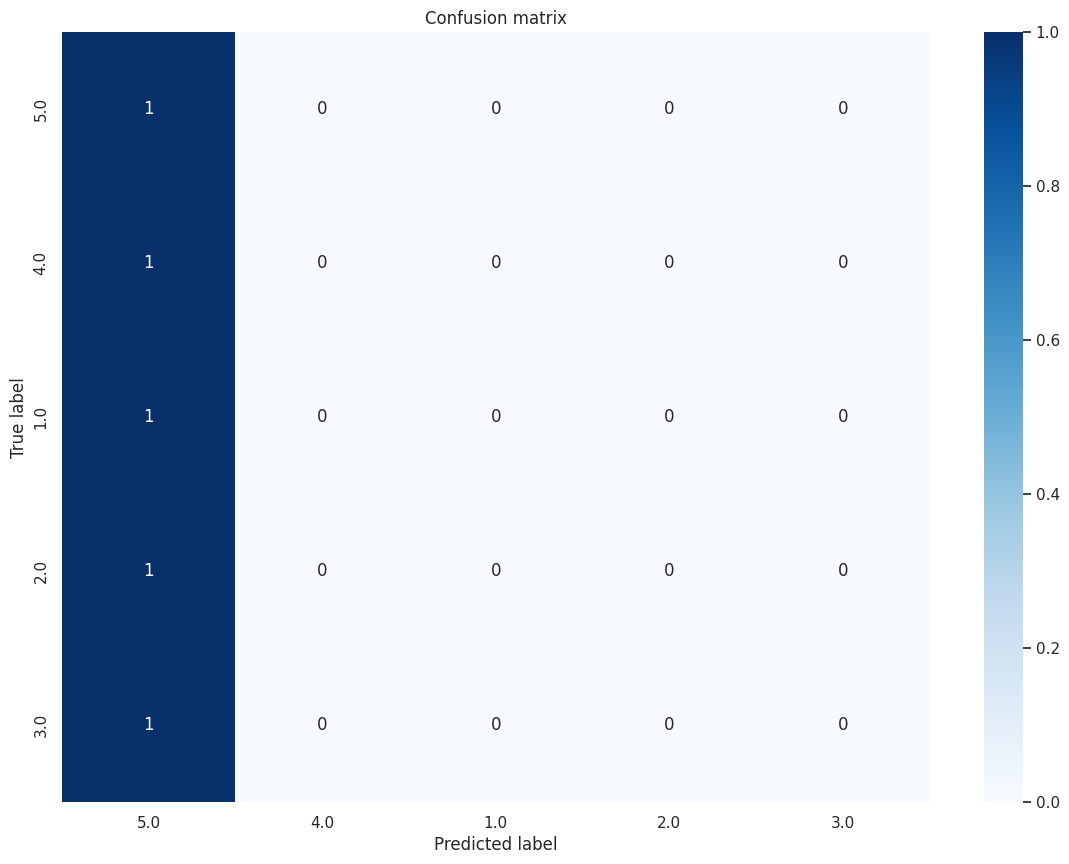

In [79]:
matrix = confusion_matrix(test_y, test_predictions)
matrix_scaled = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,10))
sns.heatmap(matrix_scaled, annot=True, cmap=plt.cm.Blues, xticklabels=[inverse_mapping[i] for i in np.unique(test_y)],\
            yticklabels=[inverse_mapping[i] for i in np.unique(test_y)])
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

In [81]:
test_df = df[subsets['split']=='test'].copy()

In [82]:
test_df['predicted_rating'] = [inverse_mapping[i] for i in test_predictions]

# Save history results

In [149]:
test_results

{'test_f1_rozetka': 0.7224670745618583,
 'test_f1_tripadvisor_hotels_ukraine': 0.5496804911665205,
 'test_f1_tripadvisor_restaurants_ukraine': 0.5771900304974235,
 'test_f1_translated==True': 0.6411783493339847,
 'test_f1_translated==False': 0.7374432922877512}

In [159]:
history = pd.DataFrame()
cols = ['train_f1_rozetka', 'train_f1_tripadvisor_hotels_ukraine',
       'train_f1_tripadvisor_restaurants_ukraine', 'train_f1_translated==True',
       'train_f1_translated==False', 'val_f1_rozetka',
       'val_f1_tripadvisor_hotels_ukraine',
       'val_f1_tripadvisor_restaurants_ukraine', 'val_f1_translated==True',
       'val_f1_translated==False', 'train_f1', 'val_f1', 'train_loss',
       'val_loss', 'test_f1_rozetka', 'test_f1_tripadvisor_hotels_ukraine',
       'test_f1_tripadvisor_restaurants_ukraine', 'test_f1_translated==True',
       'test_f1_translated==False', 'model']
for i in cols:
    history[i] = [test_results.get(i, None)]

In [160]:
history['model'] = model_name

In [161]:
history

,train_f1_rozetka,train_f1_tripadvisor_hotels_ukraine,train_f1_tripadvisor_restaurants_ukraine,train_f1_translated==True,train_f1_translated==False,val_f1_rozetka,val_f1_tripadvisor_hotels_ukraine,val_f1_tripadvisor_restaurants_ukraine,val_f1_translated==True,val_f1_translated==False,train_f1,val_f1,train_loss,val_loss,test_f1_rozetka,test_f1_tripadvisor_hotels_ukraine,test_f1_tripadvisor_restaurants_ukraine,test_f1_translated==True,test_f1_translated==False,model
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.722467,0.54968,0.57719,0.641178,0.737443,roberta_base_cased


In [162]:
history.to_csv("/home/user/jupyter_notebooks/Ukranian-SA/notebooks/training/training_results_filtered.csv", mode='a', header=None, index=None)

# Save model

In [268]:
model.save(f'/home/user/files_for_research_Vova/{model_name}.h5')